<a href="https://colab.research.google.com/github/Ruanvans/ECG-classification-using-deep-learning/blob/master/ptbd_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importation of necessary libraries and tools**

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import numpy as np 
import pandas as pd 
import keras 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from keras.models import Sequential 
from keras.layers import Reshape, Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D, GlobalAveragePooling1D, AveragePooling1D
from keras.utils import to_categorical
from sklearn.utils import resample, shuffle 
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.optimizers import rmsprop
from sklearn.metrics import roc_curve, auc ,precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score
import itertools
from itertools import cycle 
import random
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM,Bidirectional, GRU
from keras import optimizers,regularizers
from keras.layers.normalization import BatchNormalization
from scipy import interp

Using TensorFlow backend.


# **Helper methods to visualize results**


In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
def model_evalutation(history, test, y_test, model):
    score = model.evaluate((test),y_test)
    print("Model Accuracy: %.2f%%" % (score[1]*100))

    plt.figure(figsize=(15,5))

    # Plot training & validation accuracy values
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')

    plt.suptitle("Model Accuracy and Model Loss")
    plt.tight_layout()
    plt.show()

In [0]:
def roc_curve_evaluation(y,y_pred, y_test):

    y = label_binarize(y, classes=[0, 1])
    n_classes = 2

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(10,10))
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))


    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

# **Data preparation and preprocessing**

in the below cell a data set called train_df is made from undersampling the majority class to ensure that the two classes of data are equal

In [0]:
#importation of datasets
df_ptb1 = pd.read_csv('ptbdb_normal.csv', header=None)
df_ptb2 = pd.read_csv('ptbdb_abnormal.csv', header=None)

#concatenation of the normal and abnormal datasets 
frames = [df_ptb1, df_ptb2]
df_ptb3 = pd.concat(frames) 
#Does a value count of the newly made concatenated dataset
df_ptb3[187] = df_ptb3[187].astype(int)
equilibre = df_ptb3[187].value_counts()
# Resampling Dataset
df_1 = df_ptb3[df_ptb3[187] == 1]
df_0 =(df_ptb3[df_ptb3[187] == 0]).sample(n=4000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=4000,random_state=123)
train_df=pd.concat([df_0,df_1_upsample])
#shuffle method used here to ensure that models are correctly trained and tested
train_df= shuffle(train_df)
#Value count on the resampled dataset
train_df[187].value_counts()

resampled = train_df[187].value_counts()

The below cell is used to create a data set called train_df_upsampled, it is composed of almost the complete abnormal class and an artificially constructed set for the normal class. This artificially constructed set is made by randomly sampling from the normal set until it is composed of 10000 samples

In [0]:
df_1_sample = (df_ptb3[df_ptb3[187] == 1]).sample(n=10000,random_state=27)
df_0_sample = df_ptb3[df_ptb3[187] == 0]

df_0_upsampled = resample(df_0_sample,replace=True, n_samples= 10000, random_state=27) 

train_df_upsampled = pd.concat([df_0_upsampled,df_1_sample])
train_df_upsampled = shuffle(train_df_upsampled)

upsampled = train_df_upsampled[187].value_counts()

visualisation of the class structures of the original, downsampled, and upsampled data sets. 

In [44]:
print("Original structure of the dataset: ")
print(equilibre)
print("Structure of the dataset when undersampled: ")
print(resampled)
print("structure of the dataset when upsampled: ")
print(upsampled)

Original structure of the dataset: 
1    10506
0     4046
Name: 187, dtype: int64
Structure of the dataset when undersampled: 
1    4000
0    4000
Name: 187, dtype: int64
structure of the dataset when upsampled: 
1    10000
0    10000
Name: 187, dtype: int64


Creation of the x and y sets for the undersampled (X,y) and upsampled (X_up, y_up) data sets to be used for training and testing the models

In [0]:
X = train_df.values[:,:-1]
y = train_df.values[:,-1]

X_up = train_df_upsampled.values[:,:-1]
y_up = train_df_upsampled.values[:,-1]

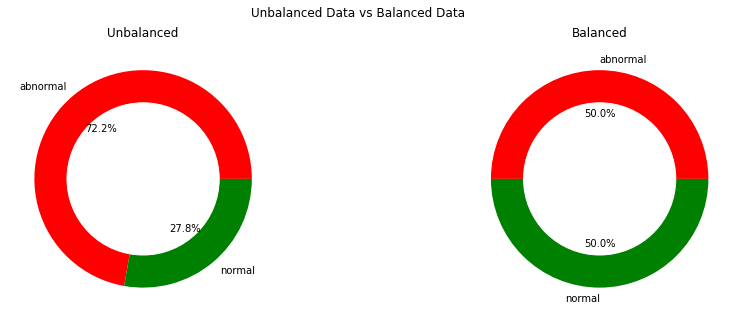

In [46]:
plt.figure(figsize=(15,5))
#unbalanced data plot
plt.subplot(1,2,1)
ptbdb_circle = plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['abnormal', 'normal'], colors=['red', 'green'], autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(ptbdb_circle)
plt.title("Unbalanced")
#balanced data plot
plt.subplot(1,2,2)
ptbdb_circle = plt.Circle( (0,0), 0.7, color='white')
plt.pie(resampled, labels=['abnormal', 'normal'], colors=['red', 'green'], autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(ptbdb_circle)
plt.title("Balanced")

plt.suptitle("Unbalanced Data vs Balanced Data")
plt.show()

In [0]:
#Train and test sets for the ANN
X_train = X[:5600]
X_test = X[5600:]

#data for the convolutional nets that needs to be reshaped
Xc = np.asarray(X)
Xc = Xc.reshape(8000,187,1)
 
Xc_train = Xc[:5600]
Xc_test = Xc[5600:]

#label data that is universally applicable
y_train = y[:5600]
y_test = y[5600:]

In [0]:
#train and test sets for the ANN
X_up_train = X_up[:14000]
X_up_test = X_up[14000:]

#data for the convolutional nets that needs to be reshaped
Xc_up = np.asarray(X_up)
Xc_up = Xc_up.reshape(20000,187,1)

Xc_up_train = Xc_up[:14000]
Xc_up_test = Xc_up[14000:]

#label data that is universally applicable
y_up_train = y_up[:14000]
y_up_test = y_up[14000:]

In [0]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_up_train = to_categorical(y_up_train)
y_up_test = to_categorical(y_up_test)

# **Basic deep neural network to establish a baseline accuracy**

In [14]:
model_1 = Sequential()
model_1.add(Dense(100, input_dim=187, activation='relu'))
model_1.add(Dense(100, activation='relu'))
model_1.add(Dense(90, activation='relu' ))
model_1.add(Dense(70, activation='relu'))
model_1.add(Dense(2, activation='sigmoid'))

print(model_1.summary())
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               18800     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 90)                9090      
_________________________________________________________________
dense_4 (Dense)              (None, 70)                6370      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 142       
Total params: 44,502
Trainable params: 44,502
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use

In [15]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2)]

history = model_1.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=callbacks ,epochs=100, batch_size=32)


Train on 5600 samples, validate on 2400 samples
Epoch 1/100
5600/5600 [==============================] - 2s 441us/step - loss: 0.5005 - accuracy: 0.7554 - val_loss: 0.4237 - val_accuracy: 0.8219
Epoch 2/100
5600/5600 [==============================] - 1s 124us/step - loss: 0.3978 - accuracy: 0.8309 - val_loss: 0.3561 - val_accuracy: 0.8527
Epoch 3/100
5600/5600 [==============================] - 1s 126us/step - loss: 0.3224 - accuracy: 0.8701 - val_loss: 0.2897 - val_accuracy: 0.8846
Epoch 4/100
5600/5600 [==============================] - 1s 123us/step - loss: 0.2664 - accuracy: 0.8977 - val_loss: 0.3200 - val_accuracy: 0.8675
Epoch 5/100
5600/5600 [==============================] - 1s 125us/step - loss: 0.2410 - accuracy: 0.9085 - val_loss: 0.2415 - val_accuracy: 0.9052
Epoch 6/100
5600/5600 [==============================] - 1s 126us/step - loss: 0.2174 - accuracy: 0.9179 - val_loss: 0.2359 - val_accuracy: 0.9085
Epoch 7/100
5600/5600 [==============================] - 1s 125us/ste

2400/2400 [==============================] - 0s 50us/step
Model Accuracy: 91.29%


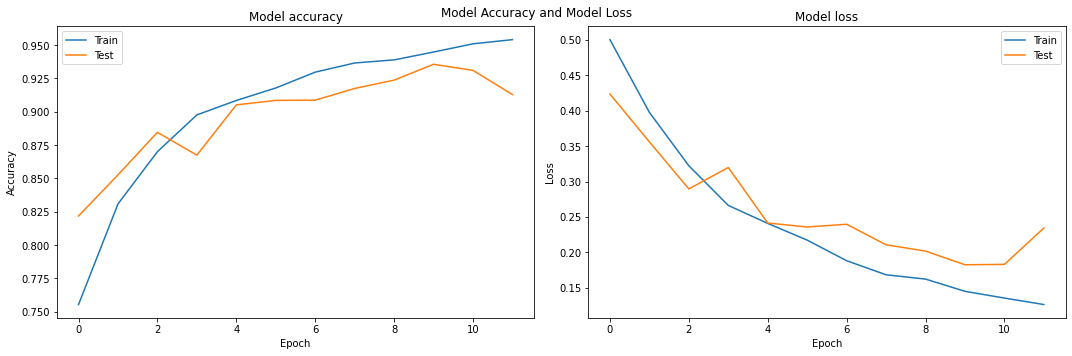

In [16]:
test = X_test
model = model_1
model_evalutation(history, test, y_test, model)

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1210
           1       0.98      0.84      0.91      1190

    accuracy                           0.91      2400
   macro avg       0.92      0.91      0.91      2400
weighted avg       0.92      0.91      0.91      2400



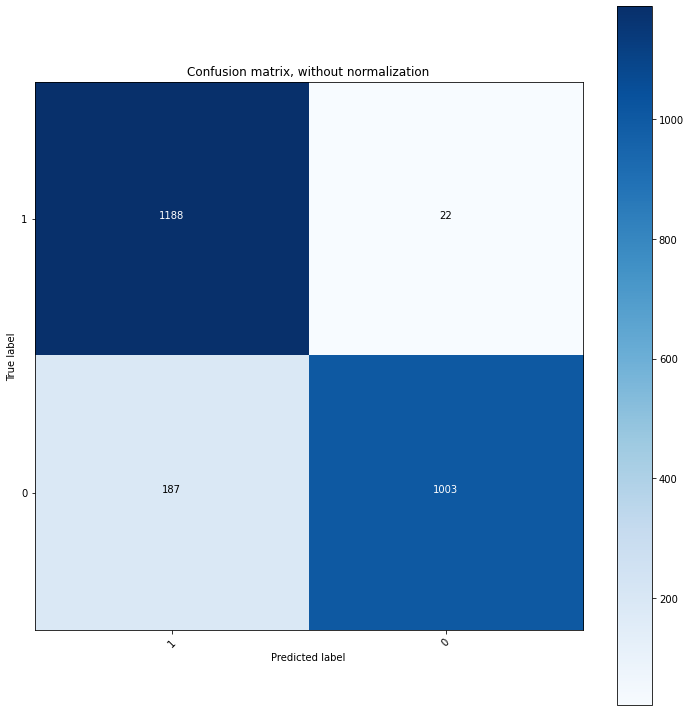

In [17]:
y_pred = model_1.predict(X_test, batch_size=1000)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['1','0'],
                      title='Confusion matrix, without normalization')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


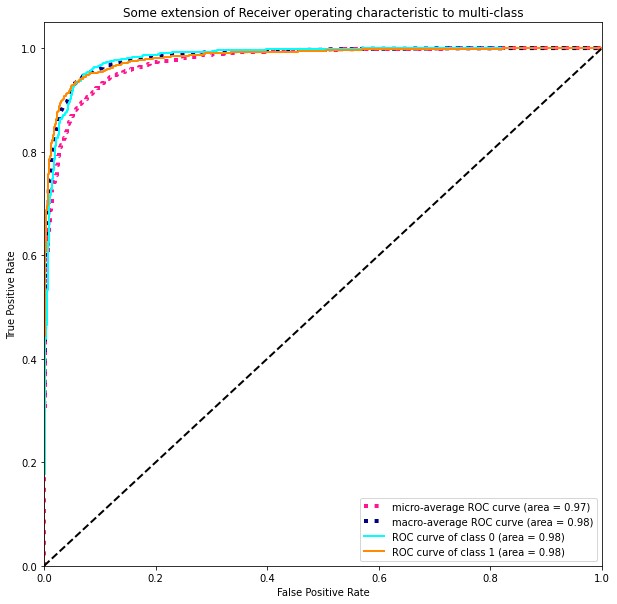

In [18]:
y = y
y_pred = model_1.predict(X_test, batch_size=1000)
y_test = y_test

roc_curve_evaluation(y, y_pred, y_test)

# **Orginal convolutional neural network**

In [24]:
model_2 = Sequential()
model_2.add(Convolution1D(100, 5, activation='relu', input_shape=(187, 1)))
model_2.add(Convolution1D(110, 5, activation='relu'))
model_2.add(Convolution1D(120, 5, activation='relu'))
model_2.add(MaxPooling1D(3))
model_2.add(Convolution1D(140, 10, activation='relu'))
model_2.add(Convolution1D(150, 10, activation='relu'))
model_2.add(Convolution1D(160, 10, activation='relu'))
model_2.add(Convolution1D(170, 10, activation='relu'))
model_2.add(Convolution1D(200, 10, activation='relu'))
model_2.add(GlobalAveragePooling1D())
model_2.add(Dropout(0.5))
model_2.add(Dense(100, activation='relu'))
model_2.add(Dense(50, activation='relu' ))
model_2.add(Dense(2, activation='softmax'))

print(model_2.summary())
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 183, 100)          600       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 179, 110)          55110     
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 175, 120)          66120     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 58, 120)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 49, 140)           168140    
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 40, 150)           210150    
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 31, 160)          

In [20]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

history = model_2.fit(Xc_train, y_train, validation_data=(Xc_test, y_test), callbacks=callbacks, epochs=40, batch_size= 32)

Train on 5600 samples, validate on 2400 samples
Epoch 1/40
5600/5600 [==============================] - 7s 1ms/step - loss: 0.6044 - accuracy: 0.6700 - val_loss: 0.5365 - val_accuracy: 0.7508
Epoch 2/40
5600/5600 [==============================] - 2s 341us/step - loss: 0.4610 - accuracy: 0.7907 - val_loss: 0.3273 - val_accuracy: 0.8662
Epoch 3/40
5600/5600 [==============================] - 2s 339us/step - loss: 0.3402 - accuracy: 0.8587 - val_loss: 0.2257 - val_accuracy: 0.9117
Epoch 4/40
5600/5600 [==============================] - 2s 339us/step - loss: 0.2320 - accuracy: 0.9112 - val_loss: 0.1695 - val_accuracy: 0.9367
Epoch 5/40
5600/5600 [==============================] - 2s 338us/step - loss: 0.2081 - accuracy: 0.9214 - val_loss: 0.1662 - val_accuracy: 0.9342
Epoch 6/40
5600/5600 [==============================] - 2s 339us/step - loss: 0.1690 - accuracy: 0.9391 - val_loss: 0.2049 - val_accuracy: 0.9221
Epoch 7/40
5600/5600 [==============================] - 2s 338us/step - loss: 

2400/2400 [==============================] - 0s 103us/step
Model Accuracy: 98.67%


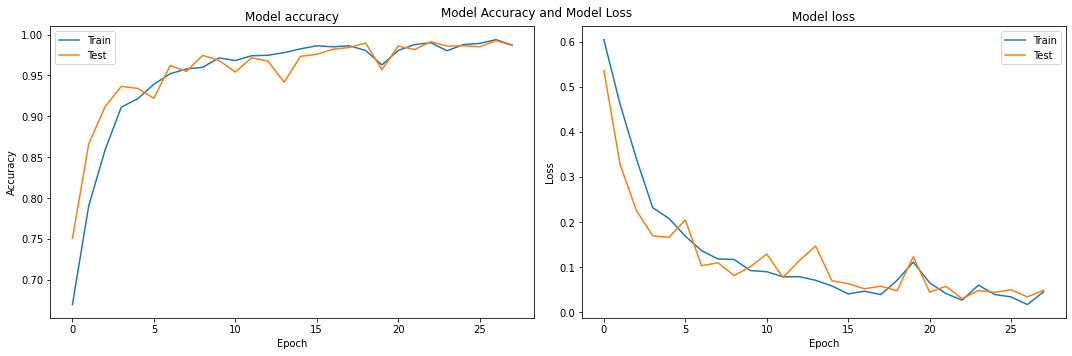

In [21]:
test = Xc_test
y_test = y_test
model = model_2
model_evalutation(history, test, y_test, model)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1210
           1       0.98      0.99      0.99      1190

    accuracy                           0.99      2400
   macro avg       0.99      0.99      0.99      2400
weighted avg       0.99      0.99      0.99      2400



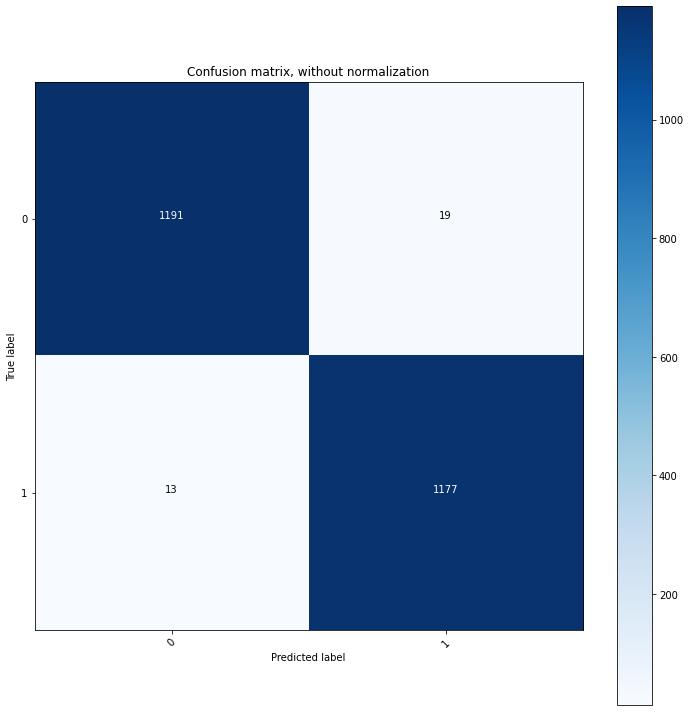

In [22]:
y_pred = model_2.predict(Xc_test, batch_size=1000)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion matrix, without normalization')
plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


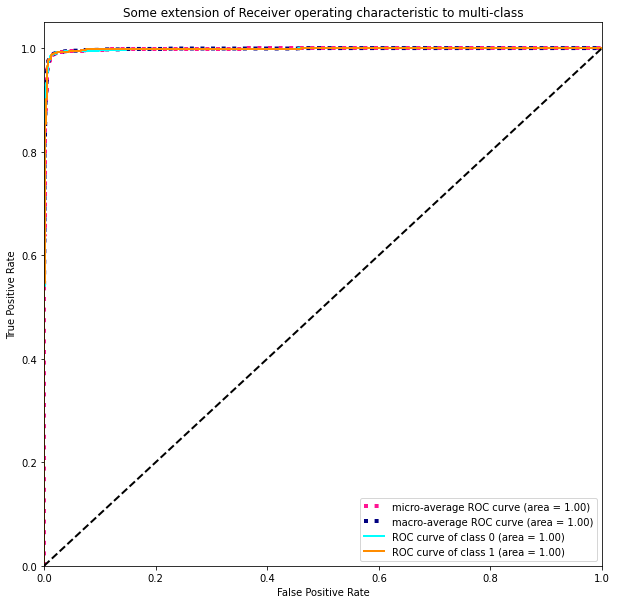

In [23]:
y = y 
y_pred = model_2.predict(Xc_test, batch_size=1000)
y_test = y_test

roc_curve_evaluation(y, y_pred, y_test)

this is the same model architecture as used above however the bigger upsampled data set is used during the training and testing process to observe whether or not a larger data positively or negatively impacts the accuracy of the model

In [25]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

history = model_2.fit(Xc_up_train, y_up_train, validation_data=(Xc_up_test, y_up_test), callbacks=callbacks, epochs=40, batch_size= 32)

Train on 14000 samples, validate on 6000 samples
Epoch 1/40
14000/14000 [==============================] - 5s 382us/step - loss: 0.4423 - accuracy: 0.7895 - val_loss: 0.2679 - val_accuracy: 0.8917
Epoch 2/40
14000/14000 [==============================] - 5s 334us/step - loss: 0.2142 - accuracy: 0.9156 - val_loss: 0.1517 - val_accuracy: 0.9507
Epoch 3/40
14000/14000 [==============================] - 5s 333us/step - loss: 0.1380 - accuracy: 0.9492 - val_loss: 0.1708 - val_accuracy: 0.9402
Epoch 4/40
14000/14000 [==============================] - 5s 336us/step - loss: 0.0981 - accuracy: 0.9656 - val_loss: 0.0786 - val_accuracy: 0.9728
Epoch 5/40
14000/14000 [==============================] - 5s 340us/step - loss: 0.0638 - accuracy: 0.9783 - val_loss: 0.0775 - val_accuracy: 0.9800
Epoch 6/40
14000/14000 [==============================] - 5s 339us/step - loss: 0.0436 - accuracy: 0.9859 - val_loss: 0.0792 - val_accuracy: 0.9818
Epoch 7/40
14000/14000 [==============================] - 5s 33

6000/6000 [==============================] - 1s 99us/step
Model Accuracy: 99.05%


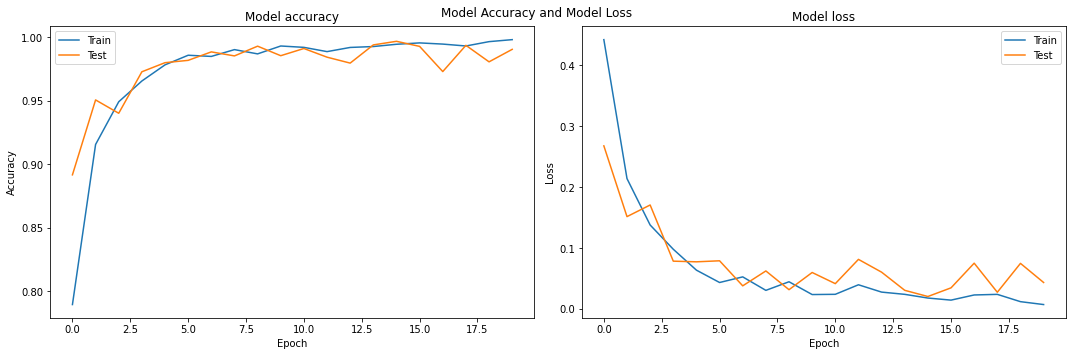

In [26]:
test = Xc_up_test
y_test = y_up_test
model = model_2
model_evalutation(history, test, y_test, model)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3033
           1       1.00      0.98      0.99      2967

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000



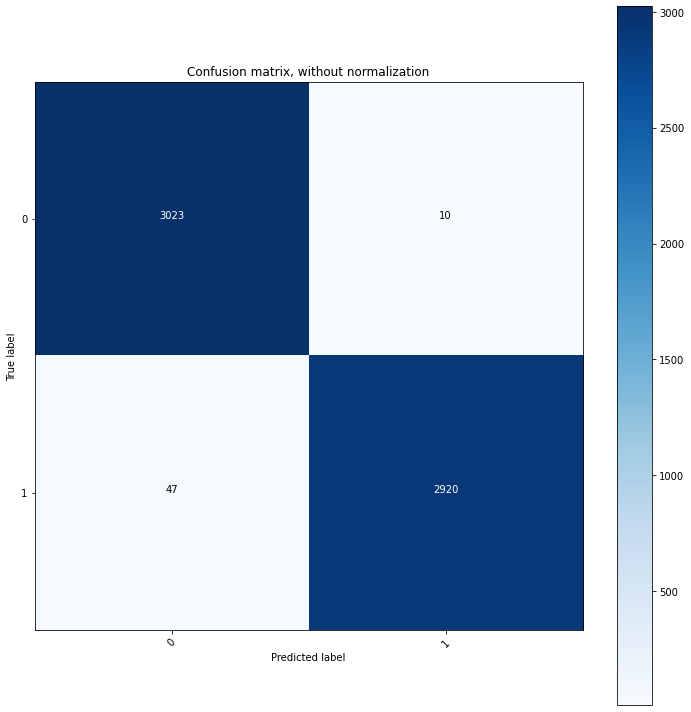

In [27]:
y_pred = model_2.predict(Xc_up_test, batch_size=1000)
print(classification_report(y_up_test.argmax(axis=1), y_pred.argmax(axis=1)))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_up_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion matrix, without normalization')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


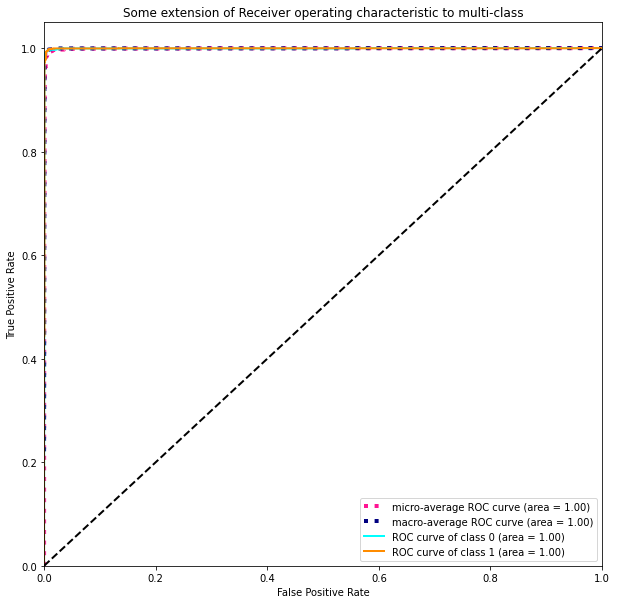

In [28]:
y = y_up
y_pred = model_2.predict(Xc_up_test, batch_size=1000)
y_test = y_up_test

roc_curve_evaluation(y, y_pred, y_test)

# **Well known convolutional neural network for comparison purposes**

In [50]:
model_3 = Sequential()
model_3.add(Convolution1D(6, 3, activation='relu', input_shape=(187, 1), padding='same'))
model_3.add(AveragePooling1D(2))
model_3.add(Convolution1D(16, 3, activation='relu', padding='valid'))
model_3.add(AveragePooling1D(2))
model_3.add(Flatten())
model_3.add(Dense(120, activation='relu'))
model_3.add(Dense(84, activation='relu'))
model_3.add(Dense(2, activation='softmax'))

print(model_3.summary())
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_23 (Conv1D)           (None, 187, 6)            24        
_________________________________________________________________
average_pooling1d_7 (Average (None, 93, 6)             0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 91, 16)            304       
_________________________________________________________________
average_pooling1d_8 (Average (None, 45, 16)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 720)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 120)               86520     
_________________________________________________________________
dense_22 (Dense)             (None, 84)               

In [51]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

history = model_3.fit(Xc_train, y_train, validation_data=(Xc_test, y_test), callbacks=callbacks , epochs=40, batch_size= 32)

Train on 5600 samples, validate on 2400 samples
Epoch 1/40
5600/5600 [==============================] - 1s 236us/step - loss: 0.5125 - accuracy: 0.7564 - val_loss: 0.4224 - val_accuracy: 0.8050
Epoch 2/40
5600/5600 [==============================] - 1s 169us/step - loss: 0.3979 - accuracy: 0.8304 - val_loss: 0.3998 - val_accuracy: 0.8112
Epoch 3/40
5600/5600 [==============================] - 1s 172us/step - loss: 0.3439 - accuracy: 0.8505 - val_loss: 0.3256 - val_accuracy: 0.8583
Epoch 4/40
5600/5600 [==============================] - 1s 170us/step - loss: 0.2914 - accuracy: 0.8800 - val_loss: 0.2514 - val_accuracy: 0.9071
Epoch 5/40
5600/5600 [==============================] - 1s 172us/step - loss: 0.2567 - accuracy: 0.8970 - val_loss: 0.2267 - val_accuracy: 0.9171
Epoch 6/40
5600/5600 [==============================] - 1s 178us/step - loss: 0.2176 - accuracy: 0.9141 - val_loss: 0.2107 - val_accuracy: 0.9225
Epoch 7/40
5600/5600 [==============================] - 1s 167us/step - loss

2400/2400 [==============================] - 0s 70us/step
Model Accuracy: 97.17%


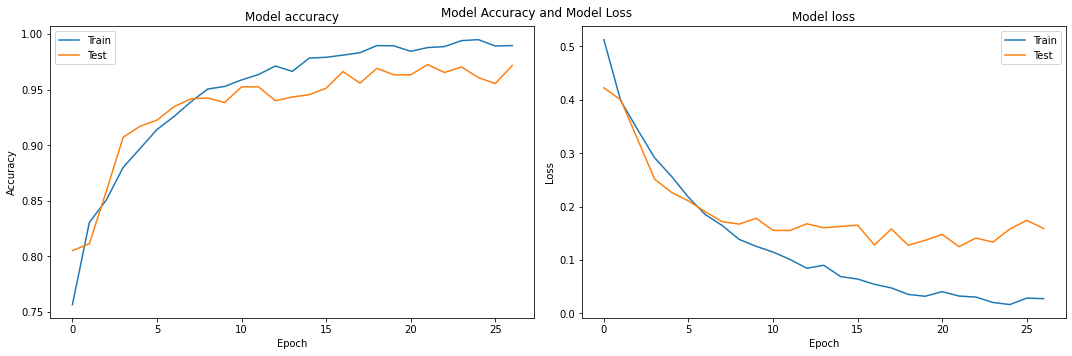

In [52]:
test = Xc_test
model = model_3
model_evalutation(history, test, y_test, model)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1196
           1       0.97      0.98      0.97      1204

    accuracy                           0.97      2400
   macro avg       0.97      0.97      0.97      2400
weighted avg       0.97      0.97      0.97      2400



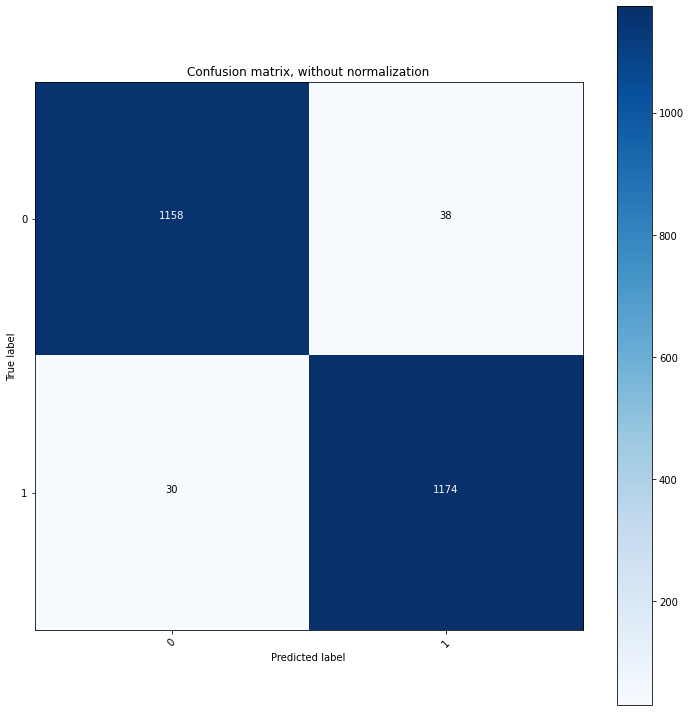

In [53]:
y_pred = model_3.predict(Xc_test, batch_size=1000)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion matrix, without normalization')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


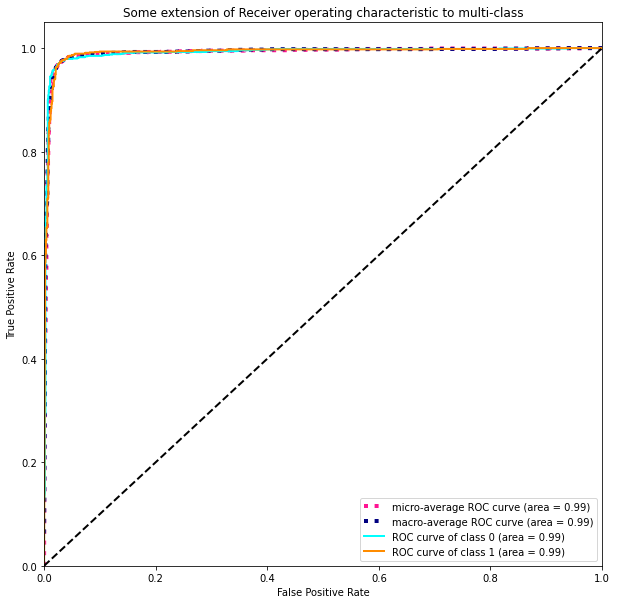

In [55]:
y = y
y_pred = model_3.predict(Xc_test, batch_size=1000)
y_test = y_test

roc_curve_evaluation(y, y_pred, y_test)

# **Original Recurrent neural network**

In [0]:
im_shape=(Xc_train.shape[1],1)

model_5= Sequential()
model_5.add(Dense(32,W_regularizer=regularizers.l2(l=0.01), input_shape=im_shape))
model_5.add(Bidirectional(LSTM(64, return_sequences=True))) #, input_shape=(seqlength, features)) ) ### bidirectional ---><---
model_5.add(Dense(32,W_regularizer=regularizers.l2(l=0.01), input_shape=im_shape))
model_5.add(Bidirectional(LSTM(64, return_sequences=True)))
model_5.add(Dropout(0.2))
model_5.add(Dense(32,W_regularizer=regularizers.l2(l=0.01), input_shape=im_shape))
model_5.add(Bidirectional(LSTM(64, return_sequences=True)))
model_5.add(Dense(32,W_regularizer=regularizers.l2(l=0.01), input_shape=im_shape))
model_5.add(Bidirectional(LSTM(64, return_sequences=True)))
model_5.add(Dropout(0.2))
model_5.add(BatchNormalization())
model_5.add(Dense(64, activation='relu',W_regularizer=regularizers.l2(l=0.01)))
model_5.add(Dense(64, activation='relu',W_regularizer=regularizers.l2(l=0.01)))
model_5.add(Dropout(0.2))
model_5.add(BatchNormalization())
model_5.add(Dense(64, activation='relu',W_regularizer=regularizers.l2(l=0.01)))
model_5.add(Dense(32, activation='relu',W_regularizer=regularizers.l2(l=0.01)))
model_5.add(Dense(2, activation='relu',W_regularizer=regularizers.l2(l=0.01)))
model_5.add(Flatten())
model_5.add(Dense(2, activation='sigmoid'))


adam = optimizers.adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy']) 
print(model_5.summary())

In [0]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
history=model_5.fit(Xc_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(Xc_test,y_test))

In [0]:
test = Xc_test
model = model_5
model_evalutation(history, test, y_test, model)

In [0]:
y_pred = model_5.predict(Xc_test, batch_size=1000)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['1','0'],
                      title='Confusion matrix, without normalization')
plt.show()

In [0]:
y = y
y_pred = model_5.predict(Xc_test, batch_size=1000)
y_test = label_test

roc_curve_evaluation(y, y_pred, y_test)